# Проект телеком

Из компании сотовой связи Телеком стали уходить клиенты. Маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых. Нужно спрогнозировать, откажется ли клиент от услуг в ближайшее время или нет.

**Целью проекта является подобрать такую модель машинного обучения с нужными гиперпараметрами, чтобы значение метрики AUC-ROC было больше или равно 0.85**

**План по выполнению проекта**

1. Подготовить данные для анализа: Загрузить данные, объеденить датасеты в один, проверить на наличие пропусков и дубликатов, изменить формат данных если потрубуется.
2. Провести разведовательский анализ данных: Посмотреть на распределение признаков, исследуем корреляцию. 
3. Обучитить разные модели: Разделим датасет на выборки тестовую и обучающую, обучим модель, подбераем модель, подбераем гиперпараметры, оценить на кросс-валидации.
4. Протестировать финальную модель, аналезировать матрицу ошибок, оценить важность признаков и сформировать отчет.

**Описание данных:**
1. BeginDate – дата начала пользования услугами,
2. EndDate – дата окончания пользования услугами,
3. Type – тип оплаты: ежемесячный, годовой и тд,
4. PaperlessBilling – электронный платёжный документ,
5. PaymentMethod – способ оплаты,
6. MonthlyCharges – ежемесячные траты на услуги по договору,
7. TotalCharges – всего потрачено денег на услуги,
8. Dependents – наличие иждивенцев,
9. Senior Citizen – наличие пенсионного статуса по возрасту,
10. Partner – наличие супруга(и),
11. MultipleLines – наличие возможности ведения параллельных линий во время звонка 


1. Основная метрика - AUC-ROC.
2. Пороговое значение основной метрики - >= 0.85.
3. Дополнительно (для отчёта) считаем и интерпретируем метрику Accuracy.


## Подготовка данных

In [1]:
#pip install phik

In [2]:
#Загружаем библиотеки
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import phik
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from catboost import cv
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
from sklearn.metrics import confusion_matrix

In [3]:
# Загружаем данные
data1 = pd.read_csv('/datasets/contract_new.csv')
data2 = pd.read_csv('/datasets/personal_new.csv')
data3 = pd.read_csv('/datasets/internet_new.csv')
data4 = pd.read_csv('/datasets/phone_new.csv')

In [4]:
RANDOM_STATE = 190623

In [5]:
#  Создадим функцию для вывода данных о датасете
def info_check(df1):
    print('-----------Информация о датасете-----------')
    df1.info()
    print('--------------Описание данных--------------')
    print(df1.describe())
    print('-----------Проверка на дубликаты-----------')
    print(df1.duplicated().sum())
    print('-----------Проверка на пропуски------------')
    print(df1.isna().sum())
    print('----------Первые 10 строк датасета---------')
    print(df1.head(10))

In [6]:
info_check(data1)

-----------Информация о датасете-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
--------------Описание данных--------------
       MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000
-----------Проверка на дубликаты-----------
0
-----------Проверка на пропуски-------

In [7]:
info_check(data2)

-----------Информация о датасете-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
--------------Описание данных--------------
       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
-----------Проверка на дубликаты-----------
0
-----------Проверка на пропуски------------
customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64
----------Первые 10 строк датасета---------
   customerID  gender 

In [8]:
info_check(data3)

-----------Информация о датасете-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
--------------Описание данных--------------
        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     2482-CZGBB     Fiber optic             No           No   
freq             1            3096      

In [9]:
info_check(data4)

-----------Информация о датасете-----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
--------------Описание данных--------------
        customerID MultipleLines
count         6361          6361
unique        6361             2
top     2482-CZGBB            No
freq             1          3390
-----------Проверка на дубликаты-----------
0
-----------Проверка на пропуски------------
customerID       0
MultipleLines    0
dtype: int64
----------Первые 10 строк датасета---------
   customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes
5  7892-POOKP           Yes
6  6388-TABGU            No
7  9763-GRSKD      

После загрузки и ознакомления с датасетами, обнаружил отсутсвие дубликатов и пропусков(вторые появятся скорее всего после объеденения таблиц с данными). Первый датасет хранит информацию о договорах с клиентами. Можно заметить что столбец EndDate(Дата окончания усулуг) имеет значения либо No, что означает что клиент еще пользуется услугами, либо дату, что означает когда клиент перестал пользоваться услугами. Этот столбец и будет нашим целевым признаком. Также можно заметить, что все табилцы имеют первичный ключ по которому мы будем объеденять их - customerID(уникальный присваемый код для каждого клиента). Второй датасет хранит информацию о самих клиентах: пол, пенсионный статус, супруги, наличие иждевенцев. Описание данных к третьему проекту отсутствует, но используя переводчик я понял, что он хранит информацию о дополнительных услугах таких как телевиденье или антивирус. Последний датасет отвечает за наличие возможности ведения параллельных линий во время звонка.

## Иследовательский анализ данных

Для построения графиков создадим новый столбец в котором присвоим булевое значение для тех кто еще пользуется услугами - 0, для тех кто закончил пользоваться услугами - 1.

In [10]:
data1.loc[data1['EndDate'] == 'No', 'EndDateBull'] = 0
data1.loc[data1['EndDate'] != 'No', 'EndDateBull'] = 1

In [11]:
data1.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDateBull
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,0.0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,0.0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,0.0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,0.0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,0.0
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96,0.0
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0.0
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48,0.0
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68,0.0
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,1.0


[Text(0.5, 0, 'Кто ушли                 Кто остались'),
 Text(0, 0.5, 'Количество людей')]

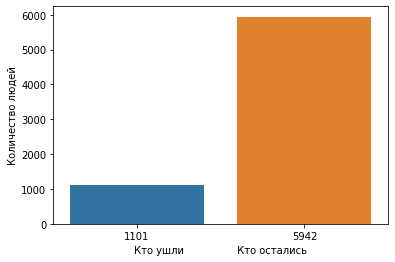

In [12]:
f = data1['EndDateBull'].value_counts()
sns.barplot(data= f, x = f[0:], y = f[:1]).set(xlabel='Кто ушли                 Кто остались', ylabel='Количество людей')

Классы жутко не сбалансированны соотношение 6к1

На графике видно, что почти 6тысяч клиентов еще пользуются услугами и чуть больше тысячи клиентов прекратили пользоваться услугами. Построим график оттока клиентов по дате, чтобы определить в какой период клиенты чаще перестают пользоваться услугами Телекома.

In [13]:
data1.loc[data1['EndDateBull'] == 1].groupby('EndDate').agg({'customerID':'count'}).style.bar()

,customerID
EndDate,
2014-06-01,1
2014-09-01,2
2014-10-01,1
2014-11-01,1
2014-12-01,2
2015-01-01,5
2015-02-01,4
2015-03-01,3
2015-04-01,2


На графике видно что массовый отток клиентов был зарегестрирован в 2018 год в ноябре - 35 человек, после чего отток клиентов уменьшился до 25 и снова увеличился в 2019 году в декабре - 39 человек и далее 40. Да на графике видно, что в последнее время клиентов уходит все больше, поэтому компания телеком и обратилась за помощью.

Теперь нужно объеденить таблицы.

In [14]:
df = (data1
    .merge(data2, on =['customerID'], how='left')
    .merge(data3, on =['customerID'], how='left')
    .merge(data4, on =['customerID'], how='left')
)

In [15]:
info_check(df)

-----------Информация о датасете-----------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   EndDateBull       7043 non-null   float64
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16

После объеденения таблиц можно заметить, что появились пропуски. Это связанно с тем, что в третьем и четвертом датасете хранилась информация не для всех пользователей. Означает что не все пользователи пользовались дополнительными услугами. Мы можем заменить пропуски NaN на значение No. Смысл не поменяется клиент не пользуется этими услугами.

In [16]:
df.fillna('No', inplace=True)

In [17]:
df.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
EndDateBull         0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

После исследовательского анализа данных мы обнаружили , что более тысяч человек перестали пользоваться услугами. Большой отток клиентов был зарегестрирован в ноябре 2018 и в декабре 2019 года. Так же во время иследовательского анализа данных я объеденил все таблицы и избавился от пропусков заменив все значение доп услуг на значение No. Теперь можно приступить к обучению модели.

## Обучение Модели

Для обучения я выбрал две модели КатБуст и СлучайныйЛес. 
1. Разделим выборки.
2. Закодируем признаки в числовые.
4. Обучим модели.
5. Протестируем финальную модель на тестовой выборке

Добавим новый признак, который считает сколько дней человек является клиентом. Для этого изменим тип данных в столбцах BeginDate и EndDate. В столбце EndDate поставим заглушку с датой выгрузки данных, чтобы посчитать дни

In [18]:
print(max(df.BeginDate))

2020-02-01


Выгрузка данных закончилась 2020-02-01, заменим все значения No на дату выгрузки данных

In [19]:
df['BeginDate'] =  df['BeginDate'].apply(pd.to_datetime)
df.EndDate = df.EndDate.replace('No','2020-02-01')
df['EndDate'] =  df['EndDate'].apply(pd.to_datetime)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   object        
 8   EndDateBull       7043 non-null   float64       
 9   gender            7043 non-null   object        
 10  SeniorCitizen     7043 non-null   int64         
 11  Partner           7043 non-null   object        
 12  Dependents        7043 non-null   object        
 13  InternetService   7043 non-null   object        
 14  OnlineSecurity    7043 n

In [20]:
df['daycount'] = (df['EndDate'] - df['BeginDate']).dt.days
df.head(10)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDateBull,gender,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,daycount
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,0.0,Female,...,No,DSL,No,Yes,No,No,No,No,No,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,0.0,Male,...,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,0.0,Male,...,No,DSL,Yes,Yes,No,No,No,No,No,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.6,0.0,Male,...,No,DSL,Yes,No,Yes,Yes,No,No,No,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.5,0.0,Female,...,No,Fiber optic,No,No,No,No,No,No,No,153
5,9305-CDSKC,2019-03-01,2020-02-01,Month-to-month,Yes,Electronic check,99.65,1150.96,0.0,Female,...,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes,337
6,1452-KIOVK,2018-04-01,2020-02-01,Month-to-month,Yes,Credit card (automatic),89.10,2058.21,0.0,Male,...,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes,671
7,6713-OKOMC,2019-04-01,2020-02-01,Month-to-month,No,Mailed check,29.75,300.48,0.0,Female,...,No,DSL,Yes,No,No,No,No,No,No,306
8,7892-POOKP,2017-07-01,2020-02-01,Month-to-month,Yes,Electronic check,104.80,3573.68,0.0,Female,...,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes,945
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35,1.0,Male,...,Yes,DSL,Yes,Yes,No,No,No,No,No,882


In [21]:
# Избавимся от ненужных признаков, которые будут мешать в машинном обучении.
final_df = df.drop(columns=['customerID', 'BeginDate', 'EndDate'], axis=1)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   object 
 5   EndDateBull       7043 non-null   float64
 6   gender            7043 non-null   object 
 7   SeniorCitizen     7043 non-null   int64  
 8   Partner           7043 non-null   object 
 9   Dependents        7043 non-null   object 
 10  InternetService   7043 non-null   object 
 11  OnlineSecurity    7043 non-null   object 
 12  OnlineBackup      7043 non-null   object 
 13  DeviceProtection  7043 non-null   object 
 14  TechSupport       7043 non-null   object 
 15  StreamingTV       7043 non-null   object 
 16  StreamingMovies   7043 non-null   object 


In [22]:
final_df[final_df['TotalCharges'] == ' ']

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDateBull,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,daycount
488,Two year,Yes,Bank transfer (automatic),52.55,,0.0,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No,0
753,Two year,No,Mailed check,20.25,,0.0,Male,0,No,Yes,No,No,No,No,No,No,No,No,0
936,Two year,No,Mailed check,80.85,,0.0,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
1082,Two year,No,Mailed check,25.75,,0.0,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes,0
1340,Two year,No,Credit card (automatic),56.05,,0.0,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,No,0
3331,Two year,No,Mailed check,19.85,,0.0,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,0
3826,Two year,No,Mailed check,25.35,,0.0,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes,0
4380,Two year,No,Mailed check,20.00,,0.0,Female,0,Yes,Yes,No,No,No,No,No,No,No,No,0
5218,One year,Yes,Mailed check,19.70,,0.0,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,0
6670,Two year,No,Mailed check,73.35,,0.0,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0


В стоблце TotalCharges мы видим пропуски, и у всех одна и таже дата - это дата выгрузки данных. Заменим значения на 0.

In [23]:
final_df.loc[final_df['TotalCharges'] == ' ', 'TotalCharges'] = 0

In [24]:
final_df[final_df['TotalCharges'] == 0]

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDateBull,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,daycount
488,Two year,Yes,Bank transfer (automatic),52.55,0,0.0,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No,0
753,Two year,No,Mailed check,20.25,0,0.0,Male,0,No,Yes,No,No,No,No,No,No,No,No,0
936,Two year,No,Mailed check,80.85,0,0.0,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0
1082,Two year,No,Mailed check,25.75,0,0.0,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes,0
1340,Two year,No,Credit card (automatic),56.05,0,0.0,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,No,0
3331,Two year,No,Mailed check,19.85,0,0.0,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,0
3826,Two year,No,Mailed check,25.35,0,0.0,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes,0
4380,Two year,No,Mailed check,20.00,0,0.0,Female,0,Yes,Yes,No,No,No,No,No,No,No,No,0
5218,One year,Yes,Mailed check,19.70,0,0.0,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,0
6670,Two year,No,Mailed check,73.35,0,0.0,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0


In [25]:
final_df['TotalCharges'] = final_df['TotalCharges'].astype('float')

In [26]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   EndDateBull       7043 non-null   float64
 6   gender            7043 non-null   object 
 7   SeniorCitizen     7043 non-null   int64  
 8   Partner           7043 non-null   object 
 9   Dependents        7043 non-null   object 
 10  InternetService   7043 non-null   object 
 11  OnlineSecurity    7043 non-null   object 
 12  OnlineBackup      7043 non-null   object 
 13  DeviceProtection  7043 non-null   object 
 14  TechSupport       7043 non-null   object 
 15  StreamingTV       7043 non-null   object 
 16  StreamingMovies   7043 non-null   object 


In [27]:
# Построим матрицу корреляций чтобы оценить зависимость признаков или удалить ненужные признаки.
final_df.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'daycount'])

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,EndDateBull,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,daycount
Type,1.000000,0.106860,0.277462,0.388444,0.470860,0.094015,0.000000,0.086231,0.179736,0.147680,0.505187,0.152145,0.098884,0.137610,0.179999,0.066961,0.069608,0.065498,0.634155
PaperlessBilling,0.106860,1.000000,0.370495,0.467812,0.201703,0.083398,0.000000,0.242133,0.013218,0.172593,0.231438,0.000000,0.196443,0.160796,0.055929,0.343524,0.325551,0.252972,0.026799
PaymentMethod,0.277462,0.370495,1.000000,0.399526,0.335666,0.214832,0.000000,0.292725,0.243008,0.224903,0.323886,0.262911,0.282475,0.306866,0.272101,0.377209,0.378907,0.339313,0.350964
MonthlyCharges,0.388444,0.467812,0.399526,1.000000,0.710905,0.226280,0.008175,0.304985,0.203545,0.184366,0.919002,0.551621,0.629541,0.667481,0.576525,0.835340,0.833307,0.675883,0.387727
TotalCharges,0.470860,0.201703,0.335666,0.710905,1.000000,0.302890,0.000000,0.135650,0.381958,0.084247,0.490081,0.522090,0.622445,0.640977,0.550065,0.641488,0.643210,0.573191,0.848337
EndDateBull,0.094015,0.083398,0.214832,0.226280,0.302890,1.000000,0.008581,0.086159,0.226688,0.046871,0.056621,0.132594,0.229482,0.218380,0.103652,0.200198,0.222232,0.261237,0.374569
gender,0.000000,0.000000,0.000000,0.008175,0.000000,0.008581,1.000000,0.000000,0.000000,0.000000,0.000000,0.018397,0.009882,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
SeniorCitizen,0.086231,0.242133,0.292725,0.304985,0.135650,0.086159,0.000000,1.000000,0.016992,0.324576,0.160702,0.057028,0.102065,0.090686,0.092565,0.163120,0.186141,0.221313,0.063315
Partner,0.179736,0.013218,0.243008,0.203545,0.381958,0.226688,0.000000,0.016992,1.000000,0.652122,0.000000,0.221673,0.219223,0.238079,0.185993,0.193258,0.182011,0.220101,0.453688
Dependents,0.147680,0.172593,0.224903,0.184366,0.084247,0.046871,0.000000,0.324576,0.652122,1.000000,0.108463,0.124945,0.031533,0.010416,0.096912,0.017331,0.058999,0.033103,0.198729


Из матрицы мы видим что признак gender не имеет зависимостей избавимся от него чтобы он не мешал в машинном обучении.

In [28]:
final_df = final_df.drop(columns=['gender'], axis=1)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   EndDateBull       7043 non-null   float64
 6   SeniorCitizen     7043 non-null   int64  
 7   Partner           7043 non-null   object 
 8   Dependents        7043 non-null   object 
 9   InternetService   7043 non-null   object 
 10  OnlineSecurity    7043 non-null   object 
 11  OnlineBackup      7043 non-null   object 
 12  DeviceProtection  7043 non-null   object 
 13  TechSupport       7043 non-null   object 
 14  StreamingTV       7043 non-null   object 
 15  StreamingMovies   7043 non-null   object 
 16  MultipleLines     7043 non-null   object 


In [29]:
# Разделим признаки и закодируем их Енкодером
features = final_df.drop('EndDateBull', axis=1)
target = final_df['EndDateBull']
features_train, features_test, target_train, target_test = train_test_split(
                                                            features, target,
                                                            test_size=0.25,
                                                            random_state=RANDOM_STATE)
print(features.shape)
print(target.shape)
print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(7043, 17)
(7043,)
(5282, 17)
(5282,)
(1761, 17)
(1761,)


In [30]:
enc = OrdinalEncoder()
cat = ['Type','PaperlessBilling','PaymentMethod','SeniorCitizen', 'Partner', 'Dependents', 
               'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
               'StreamingTV', 'StreamingMovies', 'MultipleLines']
enc.fit(features_train[cat])

OrdinalEncoder()

In [31]:
features_train[cat] = enc.transform(features_train[cat])
features_train.head(5)

/tmp/ipykernel_127/4280243978.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[cat] = enc.transform(features_train[cat])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,daycount
2298,2.0,1.0,1.0,79.2,5847.34,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2102
4028,2.0,0.0,1.0,109.2,7017.19,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1918
1587,2.0,0.0,0.0,26.3,956.79,0.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1034
669,2.0,0.0,0.0,57.8,3185.94,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1614
1791,1.0,1.0,3.0,61.5,2706.00,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1340


In [32]:
features_test[cat] = enc.transform(features_test[cat])
features_test.head(5)

/tmp/ipykernel_127/1856677410.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_test[cat] = enc.transform(features_test[cat])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,daycount
4440,2.0,1.0,2.0,60.00,2580.00,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1310
790,2.0,0.0,1.0,59.85,3806.46,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1826
2922,0.0,1.0,3.0,92.35,2272.73,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,700
1472,0.0,1.0,1.0,74.40,1116.00,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,457
722,0.0,1.0,2.0,85.95,661.82,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,215


Обучим Случайный лес при помощи Грид серч, он поможет нам подобрать лучшие параметры хоть он и время затратный.

In [33]:
model = RandomForestClassifier(class_weight='balanced', bootstrap=True, random_state=RANDOM_STATE)

#params = {
#     'n_estimators': range(100, 200, 10),
#     'max_depth': range(5,10),
#     'criterion': ['entropy'],
#     'max_features': ['sqrt']
#}

params = {
     'n_estimators': [140],
     'max_depth': [6],
     'criterion': ['entropy'],
     'max_features': ['sqrt']
}


grid_cv = GridSearchCV(
    model,
    params, 
    verbose=3,
    cv=3,
    n_jobs=-1,
    scoring='roc_auc')

In [34]:
grid_cv.fit(features_train, target_train)
grid_cv.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END criterion=entropy, max_depth=6, max_features=sqrt, n_estimators=140; total time=   0.5s
[CV 2/3] END criterion=entropy, max_depth=6, max_features=sqrt, n_estimators=140; total time=   0.4s
[CV 3/3] END criterion=entropy, max_depth=6, max_features=sqrt, n_estimators=140; total time=   0.5s


{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 'sqrt',
 'n_estimators': 140}

лучшими параметрами для случайного леса стали depth = 6 est= 140

In [35]:
grid_cv.best_score_

0.8227004405024697

На случайном лесе мы получили значение метрики AUC-0.82. Обучим катбуст через грид серч

In [36]:
model = CatBoostClassifier(loss_function='Logloss', random_seed=RANDOM_STATE,silent=True)

#catboost_params = {
# 'depth': [2, 3, 4, 5],
# 'iterations': [100, 300, 500],
# 'learning_rate': [0.1, 0.3, 0.5]
#}

catboost_params = {
 'depth': [2],
 'iterations': [500],
 'learning_rate': [0.5],
 'l2_leaf_reg':[1],
}


grid_cb = GridSearchCV(model,
                                   catboost_params, 
                                   verbose=3,
                                   cv=5,
                                   n_jobs=-1,
                                   scoring='roc_auc')

In [37]:
grid_cb.fit(features_train, target_train)
grid_cb.best_params_

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END depth=2, iterations=500, l2_leaf_reg=1, learning_rate=0.5; total time=   1.6s
[CV 2/5] END depth=2, iterations=500, l2_leaf_reg=1, learning_rate=0.5; total time=   1.2s
[CV 3/5] END depth=2, iterations=500, l2_leaf_reg=1, learning_rate=0.5; total time=   1.2s
[CV 4/5] END depth=2, iterations=500, l2_leaf_reg=1, learning_rate=0.5; total time=   1.4s
[CV 5/5] END depth=2, iterations=500, l2_leaf_reg=1, learning_rate=0.5; total time=   1.4s


{'depth': 2, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.5}

лучшими параметрами для катбуста стали depth - 4, iterations - 100, learning_rate - 0.3}

In [38]:
grid_cb.best_score_

0.9277621148659767

На катбусте мы получили значение метрики AUC-0.92

Лучшей моделью является Катбуст. Модель показала лучший результат метрики AUC - 0.92. Лучшие параметры для этой модели depth - 4, iterations - 100, learning_rate - 0.3. Можно переходить к финальному тесту на тестовой выборке

Протестируем КатБуст на тестовой выборке

In [39]:
probabilities_test = grid_cb.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print(auc_roc)

0.9371268824062907


На тестовой выборке мы получили значение AUC - 0.93. Теперь оценим важность признаков лучшей модели и посмотрим на матрицу ошибок

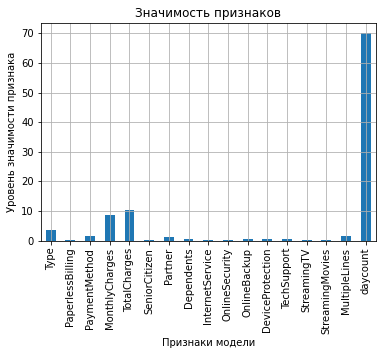

In [40]:
importances = grid_cb.best_estimator_.feature_importances_
feature_names = features_train.columns
cb_importances = pd.Series(importances, index=feature_names)
std = np.std([grid_cb.best_estimator_.feature_importances_], axis=0)
fig, ax = plt.subplots()
cb_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Значимость признаков')
plt.grid(True)
plt.xlabel("Признаки модели")
plt.ylabel("Уровень значимости признака")
fig.show()

Самым важным признаком оказался искуственно созданный признак количество дней контракта, тип услуги, ежемесечные и общие выплаты. Остальные признаки оказывают небольшое влияние на обучение модели

In [41]:
predicted_test = grid_cb.predict(features_test) 

In [42]:
accuracy_score(target_test, predicted_test)

0.9381033503691084

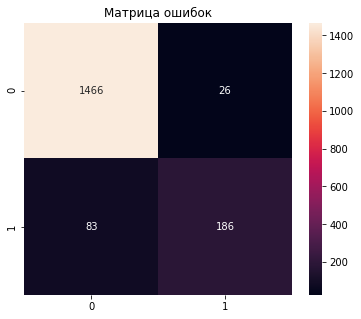

In [43]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(target_test, predicted_test),annot=True,fmt='1.0f')
plt.title('Матрица ошибок');

Из матрицы ошибок можно заметить что модель ошибалась редко, мы добились значение accuracy - 93. Это значит что у нашей модели точность 93% (процент правильных ответов) 

True Positive (истинно-положительное решение): прогноз совпал с реальностью, результат положительный произошел, как и было предсказано ML-моделью - 1466

False Positive (ложноположительное решение): ошибка 1-го рода, ML-модель предсказала положительный результат, а на самом деле он отрицательный - 26

False Negative (ложноотрицательное решение): ошибка 2-го рода – ML-модель предсказала отрицательный результат, но на самом деле он положительный - 83 

True Negative (истинно-отрицательное решение): результат отрицательный, ML-прогноз совпал с реальностью - 186

Для предсказания я выбрал 2 модели CatBoost и RandomForestClassifier. Перед обучением я создал новый признак daycount, который показывает сколько дней длится контракт. Изменил тип данных посчитал новый признак. Далее я избавился от ненужных признаков разделил выборки, закодировал их с помощью енкодера и приступил к обучению моделей. Сначало я обучил случайный лес качество модели - 0.82. После чего я обучил кат буст и протестировал на тестовой выборке. Результат - 0.92 на обучающей и 0.94 на тестовой выборке. Процент точности модели 93%. Также я оценил важность признаков и самым важным оказался искуственно созданный признак daycount. Это логично, чем дольше человек является клиентом, тем меньше шансов, что он покинет компанию. 

## Отчет

**1. Ключевые шаги работы над проектом:**
1. Ознакомился с датасетами и сразу выделил целевой признак - EndDate. Этот столбец хранит информацию о том когда закончился договор с клиентом. После чего я ознакомился с классами, они жутко не сбалансированны соотношение 6к1. 1101 клиента расторгнули договор и 5942  кто нет. 
2. Объеденил датасеты в один изза чего обнаружились пропуски в данных. Это связанно с тем, что в третьем и четвертом датасете хранилась информация не для всех пользователей. Означает что не все пользователи пользовались дополнительными услугами. Я заменил пропуски NaN на значение No. Смысл не поменяется клиент не пользуется этими услугами. Также перед обучением модели я удалил ненужные признаки которые не влияют на обучение модели: customerID, BeginDate, EndDate. Я построил матрицу корреляций в которой не увидел зависимостей столбца gender(который отвечает за пол клиента) и было решено также удалить этот столбец, чтобы он не влиял на машинное обучение. 
3. Разделил выборки на тестовую и обучающую. В датасетах было очень много категориальных признаков и для обучения модели пришлось перевести в числовые 0, 1, 2 и тд. При работе с Енкодером я обнаружил пропуски в столбце TotalCharges и у всех была одинаковая дата - дата выгрузки данных. Означало, что клиент еще не заплатил, но информация о нем уже была в базе. Было решено заменить на значение 0.
4. Приступил к обучению моделей. Для этой задачи я выбрал две модели CatBoostClassifier и RandomForestClassifier. Я подбирал лучшие гиперпараметры для обеих моделей через GridSearchCV. Это инструмент для автоматического подбирания параметров для моделей машинного обучения. GridSearchCV находит наилучшие параметры, путем обычного перебора: он создает модель для каждой возможной комбинации параметров. 
5. Модель CatBoostClassifier показала лучший результат с гипепараметрами depth - 4, iterations - 100, learning_rate - 0.3. Значение метрики AUC - 0.93. Далее я  матрицу ошибок и посчитал метрику accuracy - 0.93. Это значит что у нашей модели точность 93% (процент правильных ответов). Также я провел оценку значимости признаков, самым важным признаком оказался искуственно созданный признак daycount - количество дней контракта. Остальные признаки оказывают небольшое влияние на обучение модели.


**2. Анализ соответствия фактической работы запланированным шагам:**

В основном я следовал плану. Но некоторые пункты я делал не в той последовательности, в которой заплонировал. Большую часть предобработки данных я совершал во время обучения модели, более детально знакомясь с данными. Я обнаруживал пропуски только при кодировании данных так как они были зашифрованны под пробелы - ' '.

**3. Рефлексия над сложностями и описание путей их решения:** 
1. Первой же проблемой стала маленький результат метрики. Для улучшения качества модели я создал новый признак daycount, который считает количество дней со дня заключения договора. В итоге этот признак оказался самым значимым для обучения лучшей модели. 
2. Второй проблемой было достать информацию о важности признаков из GridSearchCV. На помощь пришел добрый преподаватель, подсказал как это правильно сделать). 
3. Но самой сложной проблемой стало передать список категориальных признаков OrdinalEncoder, тут помогла пачка с библиотекой питона. 

**4. Итоговый список признаков (с расшифровкой) для обучения модели, способы их обработки (как кодировали/стандартизировали/преобразовывали):**
1. Type - Кодировал категориальный признак с помощью  OrdinalEncoder
1. PaperlessBilling - Кодировал категориальный признак с помощью  OrdinalEncoder
2. PaymentMethod - Кодировал категориальный признак с помощью  OrdinalEncoder
3. MonthlyCharges - Не изменял
4. TotalCharges - Не изменял
5. SeniorCitizen - Кодировал категориальный признак с помощью  OrdinalEncoder  
6. Partner - Кодировал категориальный признак с помощью  OrdinalEncoder
7. Dependents - Кодировал категориальный признак с помощью  OrdinalEncoder
8. InternetService - Кодировал категориальный признак с помощью  OrdinalEncoder
9. OnlineSecurity - Кодировал категориальный признак с помощью  OrdinalEncoder
10. OnlineBackup - Кодировал категориальный признак с помощью  OrdinalEncoder
11. DeviceProtection - Кодировал категориальный признак с помощью  OrdinalEncoder
12. TechSupport - Кодировал категориальный признак с помощью  OrdinalEncoder
13. StreamingTV - Кодировал категориальный признак с помощью  OrdinalEncoder
14. StreamingMovies - Кодировал категориальный признак с помощью  OrdinalEncoder
15. MultipleLines  - Кодировал категориальный признак с помощью  OrdinalEncoder
16. daycount - Искуственно созданный признак, посчитал количество дней от BeginDate до EndDate.
17. Type - Кодировал категориальный признак с помощью  OrdinalEncoder
18. EndDateBull - Целевой признак преобразовал в 0 и 1.

**5. Краткое описание предобработки данных (проблема - что делали):**
1. Пропуски после объеденения таблиц - замена на значение No
2. Пропуски в столбце TotalCharges - замена на значение 0

**6. Сводная таблица исследованных моделей и их метрика на кросс-валидации:**

1. CatBoostClassifier - AUC 0.92
2. RandomForestClassifier - AUC 0.82

**7. Лучшая модель - название, гиперпараметры, метрика на кросс-валидации:**
1. CatBoostClassifier 
2. depth - 4, iterations - 100, learning_rate - 0.3, 
3. Метрика на кросс-валидации - 0.92

**8. Итоговая метрика на test (AUC-ROC и Accuracy):**
1. AUC-ROC - 0.93
2. Accuracy - 0.93

**9. Матрица ошибок (таблица или график + интерпретация):**

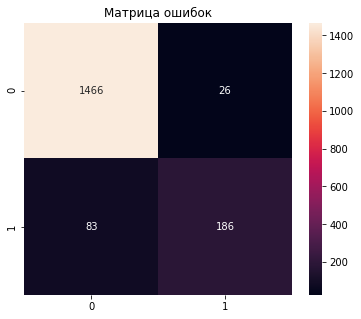

Из матрицы ошибок можно заметить что модель ошибалась редко, мы добились значение accuracy - 93. Это значит что у нашей модели точность 93% (процент правильных ответов)

True Positive (истинно-положительное решение): прогноз совпал с реальностью, результат положительный произошел, как и было предсказано ML-моделью - 1466

False Positive (ложноположительное решение): ошибка 1-го рода, ML-модель предсказала положительный результат, а на самом деле он отрицательный - 26

False Negative (ложноотрицательное решение): ошибка 2-го рода – ML-модель предсказала отрицательный результат, но на самом деле он положительный - 83

True Negative (истинно-отрицательное решение): результат отрицательный, ML-прогноз совпал с реальностью - 186

**10. Важность признаков (график + комментарии):**

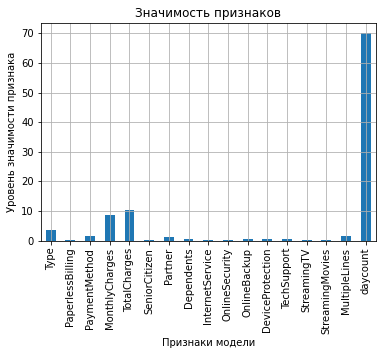

Самым важным признаком оказался искуственно созданный признак количество дней контракта. Также небольшое влияение оказывают такие признаки как ежемесечные выплаты и общие выплаты. Остальные признаки оказывают небольшое влияние на обучение модели.